<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/main/two4two_sickones_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from PIL import Image


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.benchmark = True

In [2]:
torch.__version__

'2.2.2'

# Params

In [3]:
CLASSES = ['Healthy', 'OC Degeneration']
modeltype = 'mobilenet'
ds = 'sick_ones_bendbias'

# Setup and Load Datasets

In [4]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = Path(cache_dir) / file_name

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      file_path = Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif not extract and archive_folder is not None:
       file_path = Path(cache_dir) / archive_folder
       print(f"File already extracted to: {file_path}")

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                         file_name="two4two_datasets.tar.gz",
                         cache_dir='../data', # change this if not using Colab
                         extract=False,
                         force_download=False,
                         archive_folder='two4two_datasets')
data_dir

File already exists at: ../data/two4two_datasets.tar.gz
File already extracted to: ../data/two4two_datasets


PosixPath('../data/two4two_datasets')

In [6]:
ds_dir = data_dir / ds
ds_dir

PosixPath('../data/two4two_datasets/sick_ones_bendbias')

In [7]:
# load datasets and dataloaders for pytorch processing
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')

train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

# Model Loading and Evaluation

In [8]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # remove map_location if not on mac
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [9]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [10]:
checkpoint_path = download_file(url='https://uni-bielefeld.sciebo.de/s/5uQFFsAprXT05in/download',
                                file_name='best_model.pth',
                                cache_dir='../models/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=False)
checkpoint_path

File already exists at: ../models/mobilenetv2_checkpoint/best_model.pth


PosixPath('../models/mobilenetv2_checkpoint/best_model.pth')

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Evaluate Model

In [12]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
# model.to(device)

Loaded checkpoint from: ../models/mobilenetv2_checkpoint/best_model.pth


In [ ]:

evaluate_model(model, test_dataloader, criterion, device)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/djohnson/micromamba/envs/evalxai_studies_pytorch/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/djohnson/micromamba/envs/evalxai_studies_pytorch/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ImageDataset' on <module '__main__' (built-in)>


# Data Selection

## Generate Explanation Dataset

Select 20 images to represent challenging decision making tasks but where there is a clear final decision.

(for now from nobias dataset with biased model predictions)

- 16 - Correct predictions
- 4 - Incorrect predictions

represents accuracy of model (around $80\%$)

(actually I think this does not matter.  a small sample of 20 samples will be the same as teh original model, especially in hard cases.

Will instead pick 6 total from each category

- Correct Predictions (3 each Correct and 3 Incorrect)
  - medhigh sphere diff and lowmed bend (**overlap** - ill and notill)
  - lowmed sphere diff but medhigh bend (**overlap** - ill and notill)
  - medhigh sphere diff and medhigh bend (**easy** - ill)
  - lowmed sphere diff and lowmed bend (**easy** - ill)
  - lowmed sphere diff but (1,3) changed pieces (**slightly difficult** - does XAI help show ambiguous pieces)


In [17]:
def display_images(df, n_rows, n_cols, img_dir, title, random_state=0):
  """ Function to display images in a grid randomly selected from a dataframe of images.

  Args:
    df (pd.DataFrame): dataframe of images
    n_rows (int): number of rows in the grid
    n_cols (int): number of columns in the grid
    title (str): title of the plot
    random_state (int): random state for reproducibility
  """

  if n_rows == 0 and n_cols == 0:
    print(f'Not data to display for Figure - {title}')
    return

  if n_rows * n_cols < len(df):
    df = df.sample(n_rows * n_cols, random_state=random_state)

  figsize = (n_cols * 2, n_rows*2.5)
  print(figsize)

  test_images = np.array([Image.open(p).convert('RGB') for p in img_dir / df['filename']]) * 1. / 255
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes)
  for i, (ax, idx) in enumerate(zip(axes.flat, df.index)):
    ax.imshow(test_images[i])
    ax.set_title(f'Idx: {idx} - True={df.loc[idx]["ill"]}')
    ax.axis('off')

  fig.suptitle(title)
  fig.tight_layout()

### Correct Samples Selection


In [ ]:
ill_rows = test_df['ill'] == '1'
notill_rows = test_df['ill'] == '0'

correct_rows = test_df['nobias_pred'] == test_df['ill']
incorrect_rows = test_df['nobias_pred'] != test_df['ill']

num_diff_is1 = (test_df['num_diff'] == 1)
num_diff_is2 = (test_df['num_diff'] == 2)
num_diff_is3 = (test_df['num_diff'] == 3)

In [ ]:
# areas where attributes overlap
diff_overlap = (abs(test_df[ill_rows]['sphere_diff']).min(), abs(test_df[notill_rows]['sphere_diff']).max()) 
bend_overlap = (abs(test_df[ill_rows]['bending']).min(), abs(test_df[notill_rows]['bending']).max())

# border of ill
bend_i_border = abs(test_df[ill_rows]['bending']).min()
diff_i_border = abs(test_df[ill_rows]['sphere_diff']).min()

# border of notill
bend_n_border = abs(test_df[notill_rows]['bending']).max()
diff_n_border = abs(test_df[notill_rows]['sphere_diff']).max()

print(diff_overlap, diff_i_border, diff_n_border)
print(bend_overlap, bend_i_border, bend_n_border)

(0.362658540014537, 0.499981615443567) 0.362658540014537 0.499981615443567
(0.125781852071976, 0.24985742073782502) 0.125781852071976 0.24985742073782502


In [20]:
def check_range(df, column, range):
    return (abs(df[column]) > range[0]) & (abs(df[column]) < range[1])

In [ ]:

# Harder Cases
# case 1 - Overlapping Sphere Diff and Not Ill Border Bend
c1_title = 'Overlapping Sphere Diff and Not Ill Bordering Bend'
c1_i = check_range(test_df, 'sphere_diff', diff_overlap) & check_range(test_df, 'bending', (bend_n_border, bend_n_border + 0.05))
c1_n = check_range(test_df, 'sphere_diff', diff_overlap) & check_range(test_df, 'bending', (bend_n_border - 0.05, bend_n_border))

# case 2 - Not Ill Border Sphere Diff and Overlapping Bend
c2_title = 'Not Ill Border Sphere Diff and Overlapping Bend'
c2_i = check_range(test_df, 'bending', bend_overlap) & check_range(test_df, 'sphere_diff', (diff_n_border, diff_n_border + 0.1))
c2_n = check_range(test_df, 'bending', bend_overlap) & check_range(test_df, 'sphere_diff', (diff_n_border - 0.1, diff_n_border))

# Case 3 = Overlapping Sphere Diff anid Ill Border Bend
c3_title = 'Overlapping Sphere Diff anid Ill Border Bend'
c3_i = check_range(test_df, 'sphere_diff', diff_overlap) & check_range(test_df, 'bending', (bend_i_border, bend_i_border + 0.10))
c3_n = check_range(test_df, 'sphere_diff', diff_overlap) & check_range(test_df, 'bending', (bend_i_border - 0.10, bend_i_border))

# case 4 - Ill Border Sphere Diff and Overlapping Bend
c4_title = 'Ill Border Sphere Diff and Overlapping Bend'
c4_i = check_range(test_df, 'bending', bend_overlap) & check_range(test_df, 'sphere_diff', (diff_i_border, diff_i_border + 0.1))
c4_n = check_range(test_df, 'bending', bend_overlap) & check_range(test_df, 'sphere_diff', (diff_i_border - 0.1, diff_i_border))

## Easier Cases
# Case 5 - Bordering Sphere Diff and Bordering Bend
c5_title = 'Ill Bordering Sphere Diff and Ill Bordering Bend'
c5_i = check_range(test_df, 'sphere_diff', (diff_i_border, diff_i_border + 0.1)) & check_range(test_df, 'bending', (bend_i_border, bend_i_border + 0.05))
c5_n = check_range(test_df, 'sphere_diff', (diff_n_border - 0.1, diff_n_border)) & check_range(test_df, 'bending', (bend_n_border - 0.05, bend_n_border))

# Case 6 - Low Sphere Diff and 1 or 3 Different Shapes
c6_title = 'Low Sphere Diff and 1 or 3 Different Shapes'
c6_i = check_range(test_df, 'sphere_diff', diff_overlap) & num_diff_is3
c6_n = check_range(test_df, 'sphere_diff', diff_overlap) & num_diff_is1

# Case 7 - Above or Below Overlap Regions
c7_title = 'Above or Below Overlap Regions'
c7_i = check_range(test_df, 'sphere_diff', (diff_overlap[1], 1)) & check_range(test_df, 'bending', (bend_overlap[1], 1))
c7_n = check_range(test_df, 'sphere_diff', (0, diff_overlap[0])) & check_range(test_df, 'bending', (0, bend_overlap[0])) 

In [22]:
case1_i = num_diff_is2 & ill_rows & correct_rows & c1_i
case1_n = num_diff_is2 & notill_rows & correct_rows & c1_n

case2_i = num_diff_is2 & ill_rows & correct_rows & c2_i
case2_n = num_diff_is2 & notill_rows & correct_rows & c2_n

case3_i = num_diff_is2 & ill_rows & correct_rows & c3_i
case3_n = num_diff_is2 & notill_rows & correct_rows & c3_n

case4_i = num_diff_is2 & ill_rows & correct_rows & c4_i
case4_n = num_diff_is2 & notill_rows & correct_rows & c4_n

case5_i = num_diff_is2 & ill_rows & correct_rows & c5_i
case5_n = num_diff_is2 & notill_rows & correct_rows & c5_n

case6_i = ill_rows & correct_rows & c6_i
case6_n = notill_rows & correct_rows & c6_n

case7_i = ill_rows & correct_rows & c7_i
case7_n = notill_rows & correct_rows & c7_n


In [ ]:
correct_cases = case1_i | case1_n | case2_i | case2_n | case3_i | case3_n | case4_i | case4_n | case5_i | case5_n 
correct_xai_df = pd.concat([test_df[correct_cases & ill_rows].sample(10, random_state=0), 
                            test_df[correct_cases & notill_rows].sample(10, random_state=0),
                            test_df[case6_i & ill_rows].sample(2, random_state=0),
                            test_df[case6_n & notill_rows].sample(2, random_state=0), 
                            test_df[case7_i & ill_rows].sample(2, random_state=0),
                            test_df[case7_n & notill_rows].sample(2, random_state=0)])
correct_xai_df.describe()

,spherical,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,position_x,position_y,arm_position,obj_color,bg_color,original_id,sphere_diff
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,0.0,28.000000
mean,0.447042,0.408845,2.000000,-0.044662,0.097211,0.126274,-1.311641,-0.410178,-0.390960,0.569235,0.585430,0.601475,NaN,0.464446
std,0.395609,0.223804,0.471405,0.216190,0.452533,0.466042,0.525733,0.235497,0.214501,0.201708,0.289901,0.240811,NaN,0.122864
min,0.000736,0.006505,1.000000,-0.319992,-0.680346,-0.784886,-2.208081,-0.783732,-0.716994,0.070350,0.046649,0.132617,NaN,0.227721
25%,0.060205,0.261885,2.000000,-0.242890,-0.251419,-0.235952,-1.638409,-0.610242,-0.580096,0.454645,0.328192,0.380020,NaN,0.415153
50%,0.436493,0.495620,2.000000,-0.113089,0.208087,0.103242,-1.436509,-0.377781,-0.399974,0.557799,0.683238,0.668746,NaN,0.455295
75%,0.829748,0.559919,2.000000,0.178637,0.440277,0.528790,-0.934943,-0.274825,-0.208354,0.702057,0.806322,0.806763,NaN,0.515268
max,0.999961,0.917124,3.000000,0.288280,0.776974,0.769535,-0.060332,-0.012507,-0.015100,0.928955,0.950385,0.924701,NaN,0.771671


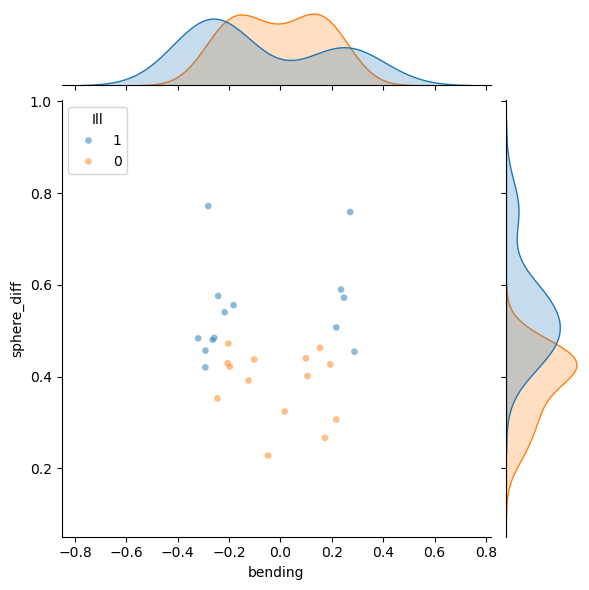

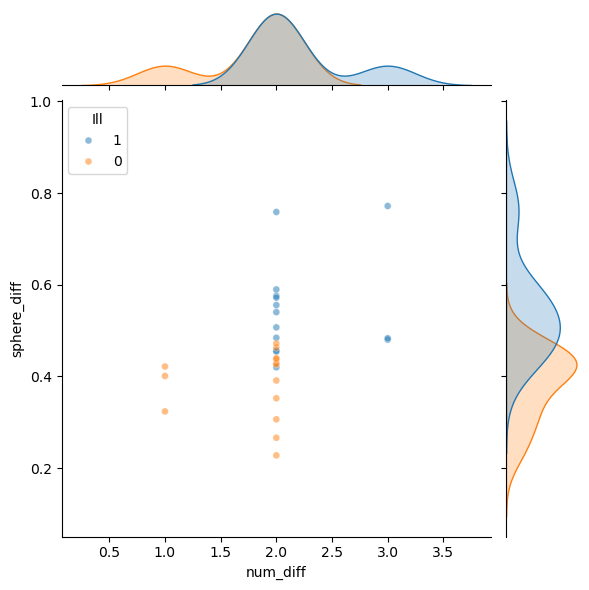

In [24]:
g = sns.jointplot(data=correct_xai_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=correct_xai_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

(12, 10.0)


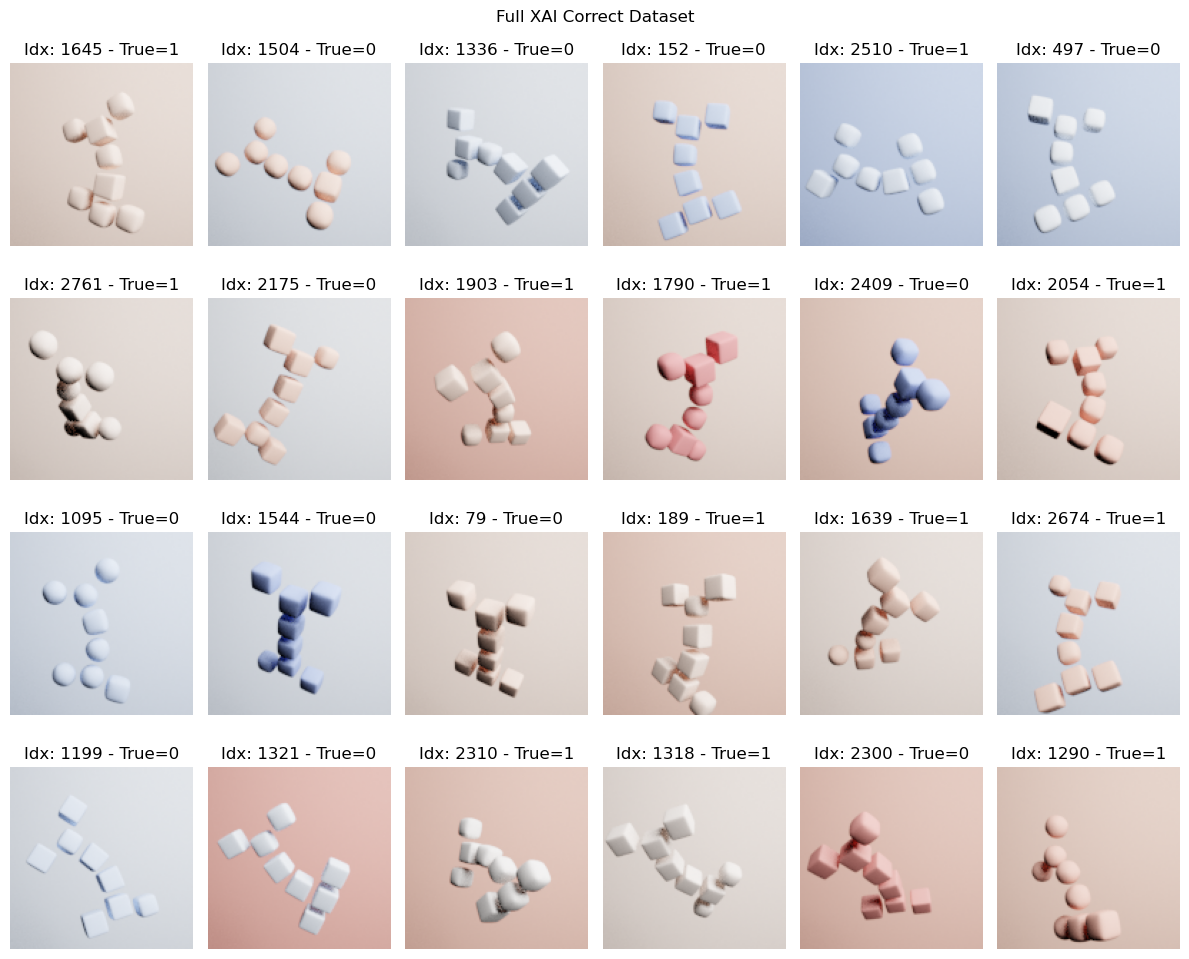

In [25]:
display_images(correct_xai_df, 4, 6, nobias_dir / 'test', f'Full XAI Correct Dataset', random_state=0)

### Incorrect Samples Selection

In [26]:
case1_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c1_i
case1_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c1_n

case2_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c2_i
case2_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c2_n

case3_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c3_i
case3_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c3_n

case4_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c4_i
case4_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c4_n

case5_i_inc = num_diff_is2 & ill_rows & incorrect_rows & c5_i
case5_n_inc = num_diff_is2 & notill_rows & incorrect_rows & c5_n

case6_i_inc = ill_rows & incorrect_rows & c6_i
case6_n_inc = notill_rows & incorrect_rows & c6_n

case7_i_inc = ill_rows & incorrect_rows & c7_i # including two from here since no incorrect preds for below
case7_n_inc = notill_rows & incorrect_rows & c7_n # no incorrect prediction meet this so leaving out

In [ ]:
test_df[case7_n_inc]

,obj_name,labeling_error,spherical,ill,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,...,resolution,id,original_id,_attributes_status,label,__module__,__name__,filename,sphere_diff,nobias_pred


In [ ]:
incorrect_cases = case1_i_inc | case1_n_inc | case2_i_inc | case2_n_inc | case3_i_inc | case3_n_inc | case4_i_inc | case4_n_inc | case5_i_inc | case5_n_inc
incorrect_xai_df = pd.concat([test_df[incorrect_cases & ill_rows].sample(5, random_state=0), 
                            test_df[incorrect_cases & notill_rows].sample(5, random_state=0),
                            test_df[case6_i_inc & ill_rows].sample(1, random_state=0),
                            test_df[case6_n_inc & notill_rows].sample(1, random_state=0),
                            test_df[case7_i_inc & ill_rows].sample(2, random_state=0)])
incorrect_xai_df.describe()

,spherical,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,position_x,position_y,arm_position,obj_color,bg_color,original_id,sphere_diff
count,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,0.0,14.000000
mean,5.176748e-01,0.519660,2.000000,0.044477,0.005527,-0.066975,-0.915647,-0.369624,-0.309779,0.549445,0.475299,0.452990,NaN,0.458139
std,4.516664e-01,0.192492,0.392232,0.215137,0.558673,0.579452,0.558231,0.183157,0.282799,0.212094,0.262272,0.239407,NaN,0.103244
min,1.176746e-12,0.242348,1.000000,-0.241241,-0.746362,-0.764848,-1.614467,-0.711311,-0.799294,0.074299,0.119097,0.072515,NaN,0.296808
25%,1.472853e-03,0.388885,2.000000,-0.173140,-0.543822,-0.652469,-1.411189,-0.498206,-0.420603,0.462985,0.226867,0.244293,NaN,0.366719
50%,6.488930e-01,0.559139,2.000000,0.179173,0.158793,-0.056331,-1.032077,-0.303760,-0.202146,0.561242,0.442863,0.501260,NaN,0.479509
75%,9.722619e-01,0.586560,2.000000,0.219967,0.395411,0.452311,-0.415620,-0.250489,-0.092014,0.677601,0.665882,0.604215,NaN,0.553783
max,9.999958e-01,0.986112,3.000000,0.286391,0.746859,0.671330,-0.087609,-0.101649,-0.004501,0.924457,0.888468,0.922666,NaN,0.592104


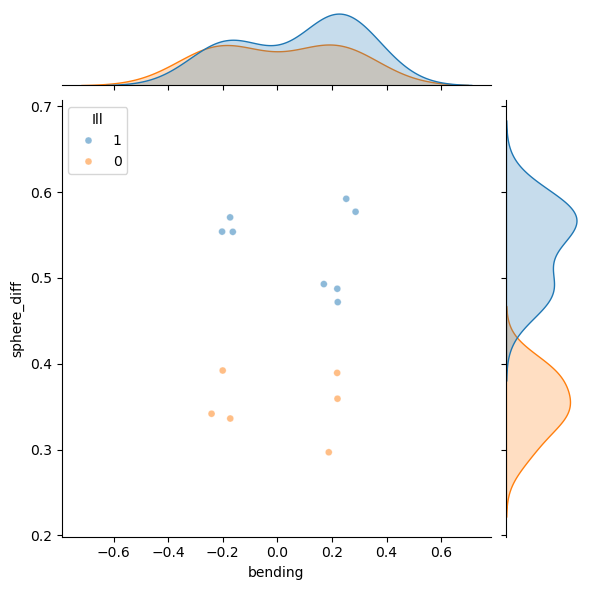

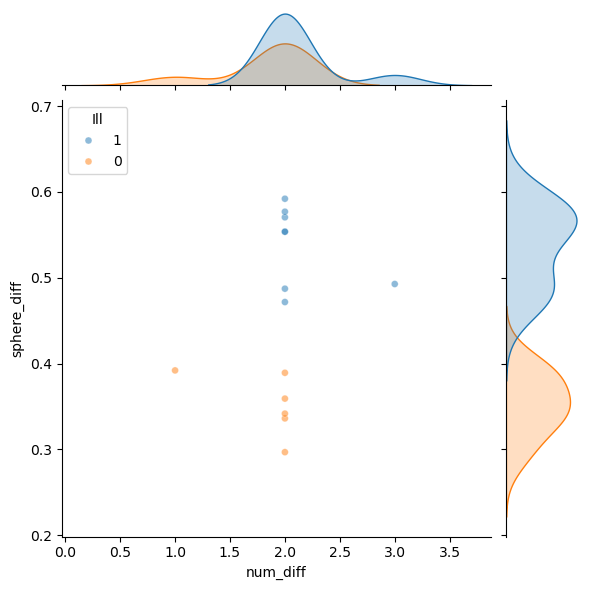

In [29]:
g = sns.jointplot(data=incorrect_xai_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=incorrect_xai_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

(14, 5.0)


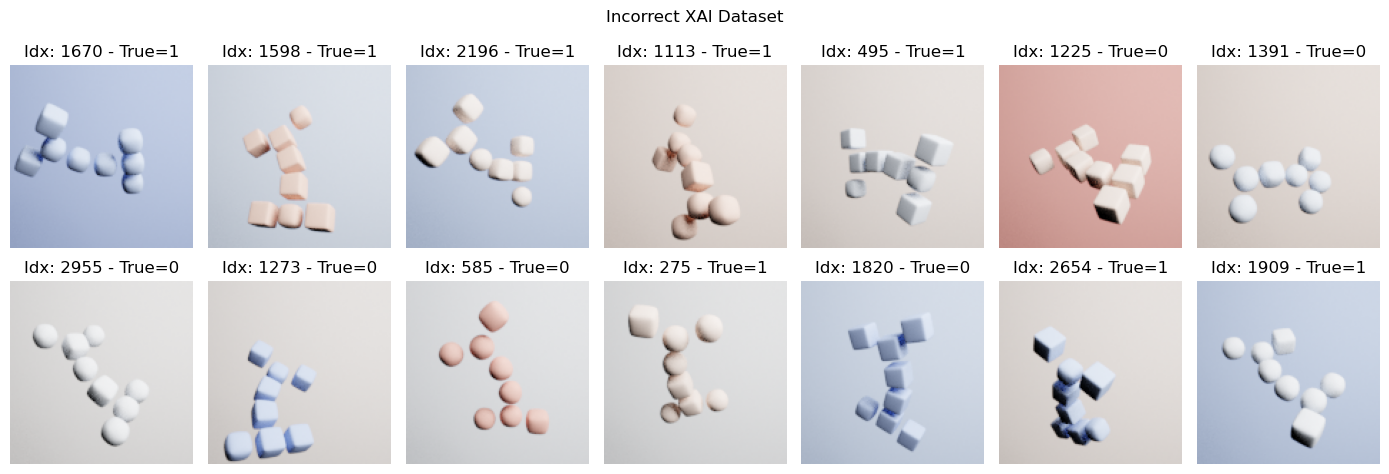

In [30]:
display_images(incorrect_xai_df, 2, 7, nobias_dir / 'test', 'Incorrect XAI Dataset')

### Combine Selections

In [31]:
final_xai_df = pd.concat([correct_xai_df, incorrect_xai_df])
len(final_xai_df), (final_xai_df['nobias_pred'] == final_xai_df['ill']).astype(int).mean()

(42, 0.6666666666666666)

(14, 15.0)


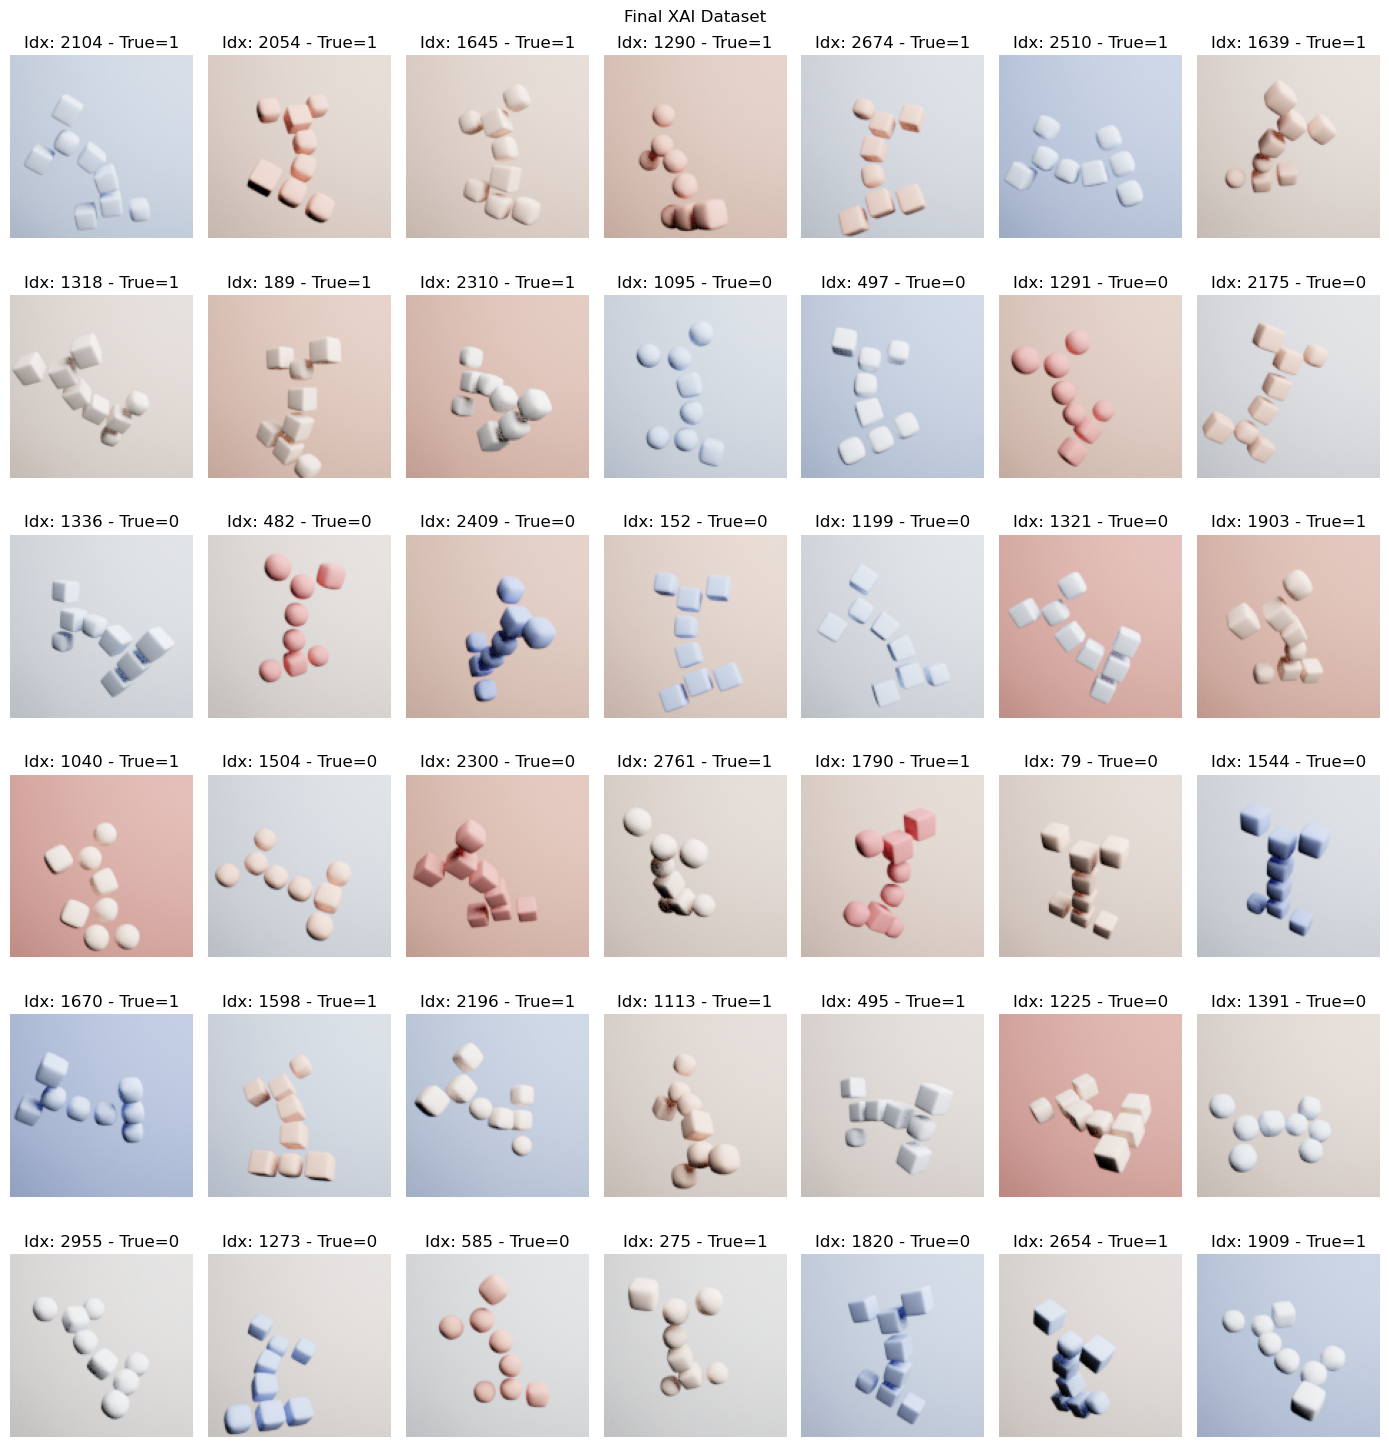

In [32]:
display_images(final_xai_df, 6, 7, nobias_dir / 'test', 'Final XAI Dataset')

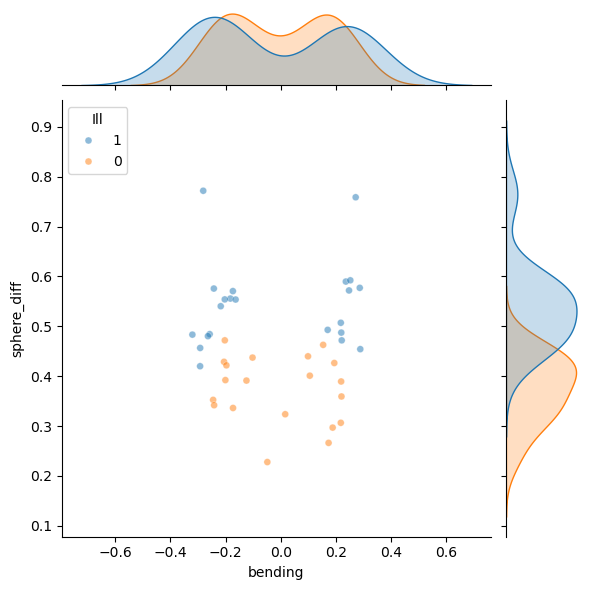

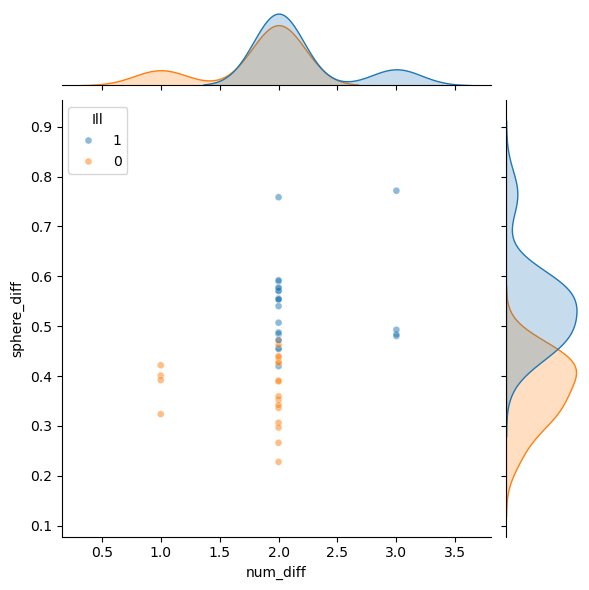

In [33]:
g = sns.jointplot(data=final_xai_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=final_xai_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

In [34]:
xai_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / final_xai_df['filename']]) * 1. / 255

#### Save Inputs

In [35]:
def show_blocky(image, id, pred=None):

  figsize = [5, 5]
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

  #plot the input image
  input_img = resize(image, (256, 256))
  ax.imshow(image)
  # title = f'ID: {id[-5:]}'
  # if pred is not None:
  #     title += f' - Model Recomendation = {"Healthy" if pred == "0" else "Cancer"}'
  # # ax.set_title(title)
  ax.axis('off')

In [36]:
today = datetime.datetime.today()
date_str = today.strftime('%Y-%m-%d')

o = output / 'original_input' / ' nobias_model' / date_str / f'xai_samples'
os.makedirs(o, exist_ok=True)
print(f'saving to {o}')

for i, ((idx, row), image) in enumerate(zip(final_xai_df.iterrows(), xai_images)):
  show_blocky(image, row["id"], None)
  plt.savefig(o / f'{row["id"]}_true={row["ill"]}_pred={row["nobias_pred"]}_input.png')
  # plt.show()
  plt.close()


# save dataframe
final_xai_df.to_csv(o / 'xai_samples_df.csv')

saving to /Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/hcxai/blocky_diagnosis/original_input/ nobias_model/2024-10-17/xai_samples


In [ ]:
# 10 easy examples for training
usertrain_df = pd.concat([test_df[case7_i & ill_rows].sample(4, random_state=0),
                          test_df[case7_n & notill_rows].sample(4, random_state=0), 
                          test_df[case7_i_inc & ill_rows].sample(2, random_state=0)])
usertrain_df.describe()

,spherical,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,position_x,position_y,arm_position,obj_color,bg_color,original_id,sphere_diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,10.000000
mean,0.565536,0.365644,1.900000,0.129128,0.000057,0.213700,-1.280733,-0.430619,-0.406418,0.553137,0.482392,0.554431,NaN,0.487368
std,0.418156,0.211065,0.737865,0.217883,0.615861,0.509135,0.599530,0.215410,0.215712,0.272579,0.331909,0.186600,NaN,0.207039
min,0.000003,0.026238,1.000000,-0.280711,-0.680346,-0.592379,-2.221763,-0.785175,-0.755517,0.095034,0.046558,0.146936,NaN,0.208653
25%,0.158724,0.260239,1.250000,-0.025693,-0.597198,-0.106768,-1.652796,-0.611242,-0.540694,0.358309,0.229524,0.451669,NaN,0.312679
50%,0.722696,0.365754,2.000000,0.165176,0.015571,0.265169,-1.373221,-0.366818,-0.380253,0.592003,0.457387,0.626193,NaN,0.552616
75%,0.934857,0.536228,2.000000,0.282691,0.569235,0.678896,-0.827665,-0.304731,-0.221996,0.744578,0.710028,0.673174,NaN,0.588329
max,0.999577,0.656223,3.000000,0.386140,0.746859,0.760855,-0.222071,-0.141097,-0.142526,0.928955,0.950385,0.732411,NaN,0.771671


In [38]:
(usertrain_df['ill'] == usertrain_df['nobias_pred']).astype(int).mean()

0.8

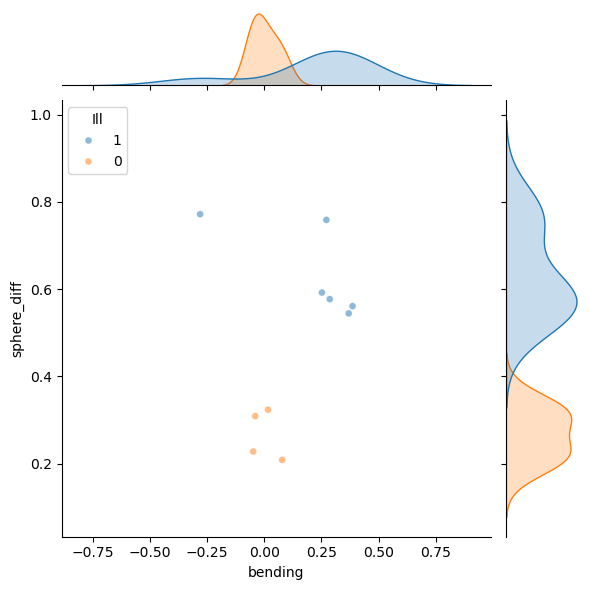

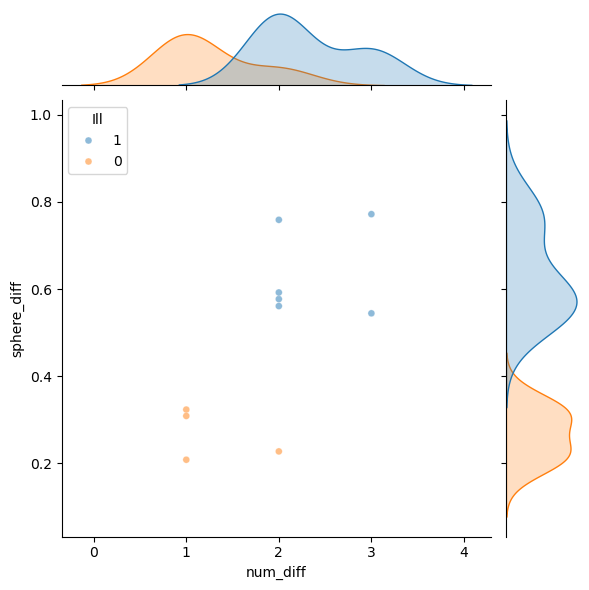

In [39]:
g = sns.jointplot(data=usertrain_df, x='bending', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

g = sns.jointplot(data=usertrain_df, x='num_diff', y='sphere_diff', hue='ill', s=25, alpha=0.5)
sns.move_legend(g.ax_joint, "upper left", title='Ill', frameon=True)

(10, 5.0)


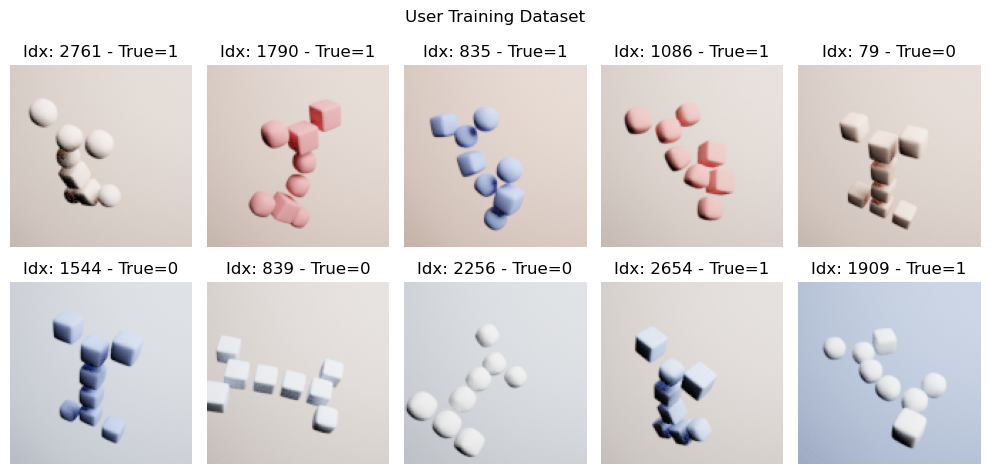

In [40]:
display_images(usertrain_df, 2, 5, nobias_dir / 'test', 'User Training Dataset')

In [45]:
training_images = np.array([Image.open(p).convert('RGB') for p in nobias_dir / 'test' / usertrain_df['filename']]) * 1. / 255

today = datetime.datetime.today()
date_str = today.strftime('%Y-%m-%d')

o = output / 'original_input' / ' nobias_model' / date_str / f'training_samples'
os.makedirs(o, exist_ok=True)
print(f'saving to {o}')

for i, ((idx, row), image) in enumerate(zip(usertrain_df.iterrows(), training_images)):
  show_blocky(image, row["id"], None)
  plt.savefig(o / f'{row["id"]}_true={row["ill"]}_pred={row["nobias_pred"]}_input.png')
  # plt.show()
  plt.close()

usertrain_df.to_csv(o / 'training_samples_df.csv')

saving to /Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive/hcxai/blocky_diagnosis/original_input/ nobias_model/2024-10-17/training_samples


In [ ]:
test_df[case7_i_inc & ill_rows].sample(2, random_state=0)

,obj_name,labeling_error,spherical,ill,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,...,resolution,id,original_id,_attributes_status,label,__module__,__name__,filename,sphere_diff,nobias_pred
2654,peaky,False,0.000003,1,0.577007,2,0.286391,0.746859,0.592318,-1.423577,...,"[128, 128]",dcab2c2e-9f11-49fc-9250-345ccbfbe2a3,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,dcab2c2e-9f11-49fc-9250-345ccbfbe2a3.png,0.577004,0
1909,stretchy,False,0.978371,1,0.386267,2,0.252192,-0.605477,-0.524300,-0.745922,...,"[128, 128]",03a5305d-4f64-4f9a-81da-d3da889cfd3c,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,03a5305d-4f64-4f9a-81da-d3da889cfd3c.png,0.592104,0


In [43]:
usertrain_df

,obj_name,labeling_error,spherical,ill,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,obj_rotation_yaw,...,resolution,id,original_id,_attributes_status,label,__module__,__name__,filename,sphere_diff,nobias_pred
2761,stretchy,False,0.999577,1,0.240943,2,0.271591,0.682350,0.760855,-1.322865,...,"[128, 128]",24808eff-f7a6-4619-bdcf-6e1735ec6ca9,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,24808eff-f7a6-4619-bdcf-6e1735ec6ca9.png,0.758635,1
1790,stretchy,False,0.797909,1,0.026238,3,-0.280711,-0.680346,0.327188,-1.834719,...,"[128, 128]",0dfbb095-b0cd-498e-a01a-787015aa630b,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,0dfbb095-b0cd-498e-a01a-787015aa630b.png,0.771671,1
835,peaky,False,0.958184,1,0.413891,3,0.369339,0.623684,-0.176095,-0.965769,...,"[128, 128]",1a1e9275-c4bc-4a00-ab91-c8c623555683,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,1a1e9275-c4bc-4a00-ab91-c8c623555683.png,0.544293,1
1086,peaky,False,0.647484,1,0.086545,2,0.386140,-0.572363,0.203149,-0.781630,...,"[128, 128]",2bad203e-f391-40f9-8c6b-846efdafc0e1,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,2bad203e-f391-40f9-8c6b-846efdafc0e1.png,0.560939,1
79,stretchy,False,0.117520,0,0.345242,2,-0.048450,0.390084,0.737296,-1.627931,...,"[128, 128]",39a16ba0-29b6-49fc-87c3-f533d09e5ca9,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,39a16ba0-29b6-49fc-87c3-f533d09e5ca9.png,0.227721,0
1544,stretchy,False,0.282337,0,0.605962,1,0.016326,0.405886,0.707756,-1.661084,...,"[128, 128]",bab2c129-8c7d-49bb-bb02-84c08581915a,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,bab2c129-8c7d-49bb-bb02-84c08581915a.png,0.323625,0
839,stretchy,False,0.009095,0,0.318126,1,-0.039700,-0.631161,0.101212,-0.222071,...,"[128, 128]",22247dcf-453b-41ec-87c8-d5de824346b6,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,22247dcf-453b-41ec-87c8-d5de824346b6.png,0.309031,0
2256,stretchy,False,0.864876,0,0.656223,1,0.078161,-0.358941,-0.592379,-2.221763,...,"[128, 128]",611758ba-6e77-4323-8a4b-d203715777b7,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,611758ba-6e77-4323-8a4b-d203715777b7.png,0.208653,0
2654,peaky,False,0.000003,1,0.577007,2,0.286391,0.746859,0.592318,-1.423577,...,"[128, 128]",dcab2c2e-9f11-49fc-9250-345ccbfbe2a3,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,dcab2c2e-9f11-49fc-9250-345ccbfbe2a3.png,0.577004,0
1909,stretchy,False,0.978371,1,0.386267,2,0.252192,-0.605477,-0.524300,-0.745922,...,"[128, 128]",03a5305d-4f64-4f9a-81da-d3da889cfd3c,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",stretchy,two4two.scene_parameters,SceneParameters,03a5305d-4f64-4f9a-81da-d3da889cfd3c.png,0.592104,0
